In [3]:
!pip install xgboost
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, matthews_corrcoef
from sklearn.impute import SimpleImputer

from imblearn.over_sampling import RandomOverSampler



In [4]:
# Load the dataset
df = pd.read_csv('AID_689_datatable_all.csv')
df.drop([0, 1, 2, 3], axis=0, inplace=True)



<ipython-input-4-fd3c1e771f7a>:2: DtypeWarning: Columns (0,7,8,9,10,11,12,13,14,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('AID_689_datatable_all.csv')


In [5]:
# Drop unnecessary columns
df.drop(['PUBCHEM_ACTIVITY_SCORE', 'PUBCHEM_ASSAYDATA_COMMENT', 'PUBCHEM_ACTIVITY_URL', 'IC50_Qualifier', 'IC50',
         'Std.Err(IC50)', 'PUBCHEM_SID', 'PUBCHEM_CID', 'nH', 'PUBCHEM_RESULT_TAG', 'PUBCHEM_EXT_DATASOURCE_SMILES'], axis=1, inplace=True)



In [6]:
# Convert specific columns to numeric
df[['%Inhibition at 10 uM', 'Mean High', 'STD Deviation High', 'Mean Low', 'STD Deviation Low']] = df[
    ['%Inhibition at 10 uM', 'Mean High', 'STD Deviation High', 'Mean Low', 'STD Deviation Low']].apply(pd.to_numeric)



In [7]:
# Create target variable
df['PUBCHEM_ACTIVITY_OUTCOME_'] = df['PUBCHEM_ACTIVITY_OUTCOME'].apply(lambda x: 1 if x == 'Active' else 0)

y = df['PUBCHEM_ACTIVITY_OUTCOME_']
X = df.drop(['PUBCHEM_ACTIVITY_OUTCOME', 'PUBCHEM_ACTIVITY_OUTCOME_'], axis=1)
RANDOM_SEED = 20




In [8]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    stratify=y,
                                                    random_state=RANDOM_SEED,
                                                    shuffle=True)



In [9]:
# Oversampling in training data
ros = RandomOverSampler(random_state=RANDOM_SEED)
X_train, y_train = ros.fit_resample(X_train, y_train)



In [10]:
# Initialize XGBoost classifier
model = xgb.XGBClassifier(n_estimators=1200,
                          max_depth=10,
                          learning_rate=0.0160001,
                          min_child_weight=18,
                          objective='binary:logistic',
                          eval_metric='logloss',
                          use_label_encoder=False)



In [11]:
# Fit the model
model.fit(X_train, y_train, early_stopping_rounds=10, eval_set=[(X_test, y_test)], verbose=200)



/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.67730
[200]	validation_0-logloss:0.02329
[400]	validation_0-logloss:0.00605
[495]	validation_0-logloss:0.00591


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.0160001, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=18, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1200,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [12]:
# Make predictions
pred = model.predict(X_test)



In [13]:
# Evaluate the model
report = classification_report(y_test, pred)
matthews_Coef = matthews_corrcoef(y_test, pred)

print("matthews_Coef: " + str(matthews_Coef))
print(report)



matthews_Coef: 0.7458311596397448
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12346
           1       0.64      0.88      0.74        16

    accuracy                           1.00     12362
   macro avg       0.82      0.94      0.87     12362
weighted avg       1.00      1.00      1.00     12362



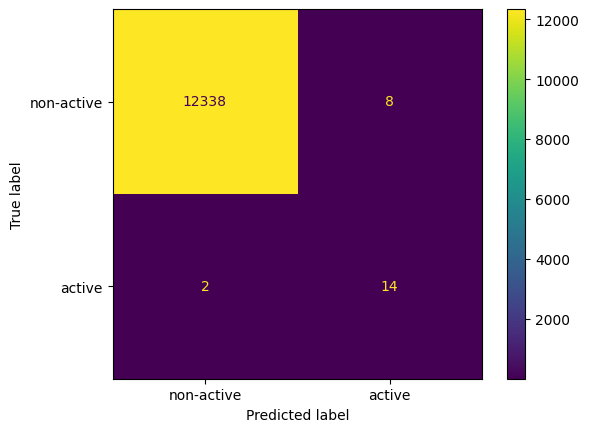

In [14]:
# Display the confusion matrix
cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['non-active', 'active'])
disp.plot()